# Анализ бизнес-показателей развлекательного приложения Procrastinate Pro+

### Описание исследования

#### Задача исследования

Требуется провести маркетинговый анализ развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

#### Исходные данные

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

### Загрузим данные и подготовим их к анализу

Импортируем нужные библиотеки.

In [141]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
import math
from datetime import datetime, timedelta

#### Предобработка данных

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

In [142]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [143]:
print(visits.info())
print(visits.isna().sum())
print(visits.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
0


In [144]:
print(orders.info())
print(orders.isna().sum())
print(orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
User Id     0
Event Dt    0
Revenue     0
dtype: int64
0


In [145]:
print(costs.info())
print(costs.isna().sum())
print(costs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
dt         0
Channel    0
costs      0
dtype: int64
0


In [146]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [147]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Проверим визуально столбцы типа object на неявные дубли.

In [148]:
print(visits['region'].value_counts())
print(visits['device'].value_counts())
print(visits['channel'].value_counts())
print(costs['channel'].value_counts())

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64
iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64
organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64
AdNonSense            180
YRabbit               180
lambdaMediaAds        180
RocketSuperAds        180
LeapBob               180
MediaTornado          180
WahooNetBanner        180
OppleCreativeMedia    180
FaceBoom              180
TipTop                180
Name: channel, dtype: int64


И проверим столбцы, отвечающие за стоимость на аномалии.

In [149]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

In [150]:
costs['costs'].describe()

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

#### Вывод
* Пропущенные значения отсутствуют
* Тип даты во всех таблицах был типа object, для корректной работы привели к datetime
* Явные дубли в таблицах отсутствуют, неявные тоже.
* Названия столбцов приведены к стандарту PEP

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [151]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [152]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [153]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [154]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [155]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [156]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [157]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [158]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [159]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [160]:
# определим минимальную дату привлечения пользователей
print(min(pd.to_datetime(profiles['first_ts']).dt.date))

2019-05-01


In [161]:
# определим минимальную дату привлечения пользователей
print(max(pd.to_datetime(profiles['first_ts']).dt.date))

2019-10-27


#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [162]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False) 

,user_id,payer
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


Пользователи приходят в приложение из следующих стран: United States, Germany, UK, France. На United States приходится больше всего платящих пользователей, у пользователей из France доля платящих ниже всех.

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [163]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False) 

,user_id,payer
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


Клиенты используют следующие устройства: Mac, iPhone, Android, PC. На MAC приходится больше всего платящих пользователей, на устройства PC - меньше всего платящих пользователей.

#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [164]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


Всего продукт использует 11 источников привлечения трафика. Доля платящих самая высокая у канала FaceBoom, а самая низкая у organic. Но organic привлекает клиентов больше остальных каналов.

### Маркетинг

#### Посчитаем общую сумму расходов на маркетинг.

In [165]:
print('Расходы на маркетинг:', round(profiles['acquisition_cost'].sum(), 1))

Расходы на маркетинг: 105497.3


#### Выясним, как траты распределены по рекламным источникам

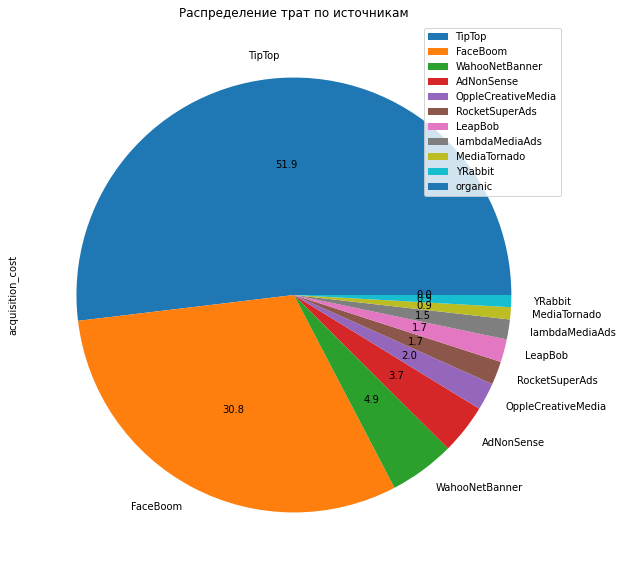

In [166]:
profiles.groupby('channel').agg(
    {'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False).plot(
    kind='pie', y = 'acquisition_cost', autopct='%.1f',
    figsize=[20, 10], 
    title='Распределение трат по источникам');

Больше всего денег на маркетинг ушло в канал TipTop - более половины от всего рекламного бюджета. На втором месте источник FaceBoom.
Наименьшие затраты у каналов YRabbit и MediaTornado. Трафик из канала organic условно бесплатный, соответственно в диаграмму не попал.

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Отразить это на одном графике.

Добавим к таблице profiles информацию о номере недели.

In [167]:
profiles['week'] = pd.to_datetime(profiles['first_ts']).dt.isocalendar().week

In [168]:
сosts_month = profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='mean')
costs_week = profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='mean')

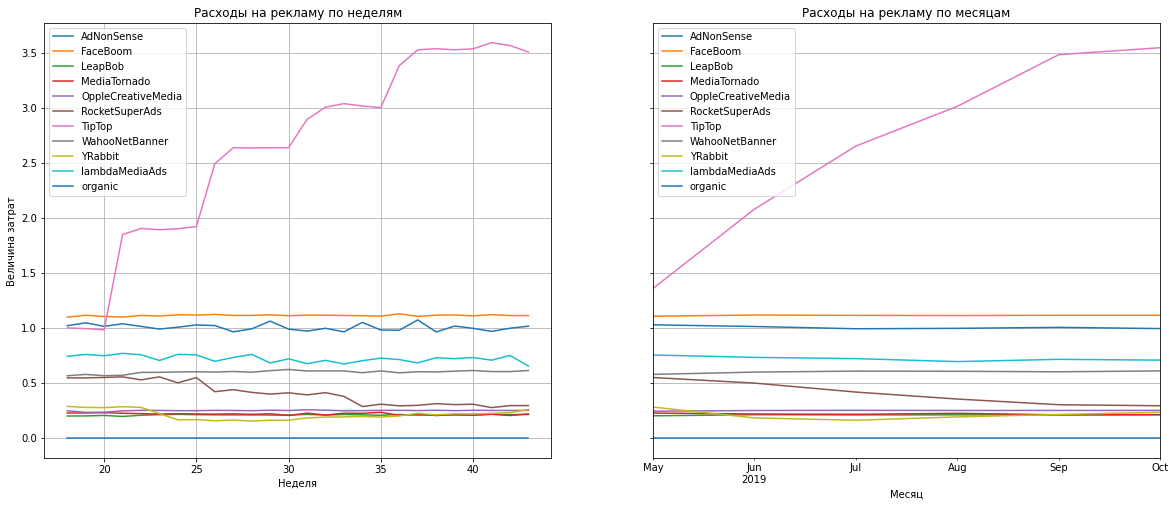

In [169]:
costs['Расходы на привлечение по месяцам'] = costs['dt'].astype('datetime64[M]')
costs['Расходы на привлечение по неделям'] = costs['dt'].astype('datetime64[W]')

columns = ['Расходы на привлечение по месяцам', 'Расходы на привлечение по неделям']

plt.subplots(figsize = (16, 5))
for i, col in enumerate(columns):
    costs.pivot_table(index = col, columns = 'channel', values = 'costs', 
                      aggfunc = 'sum').plot.area(ax = plt.subplot(1, 2, i + 1))
    plt.title(col)
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')
    plt.legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left', borderaxespad=0)
plt.show()

Расходов во времени (по неделям и месяцам) на маркетинг распределены равномерно по каждому источнику, за исключением расходов на TipTop.
После 20-ой недели началось систематическое вливание денежных средств в канал, сумма расходов на который уже в начале рассмариваего периода почти в два раза обгоняла сумму расходов второго лидера - FaceBoom.

In [171]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(
    by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


### Оценим окупаемость рекламы

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

In [172]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [173]:
# исключим органических пользователей из выборки, тк на них не идут траты рекламного бюджета
profiles_costs = profiles.query('channel != "organic"')

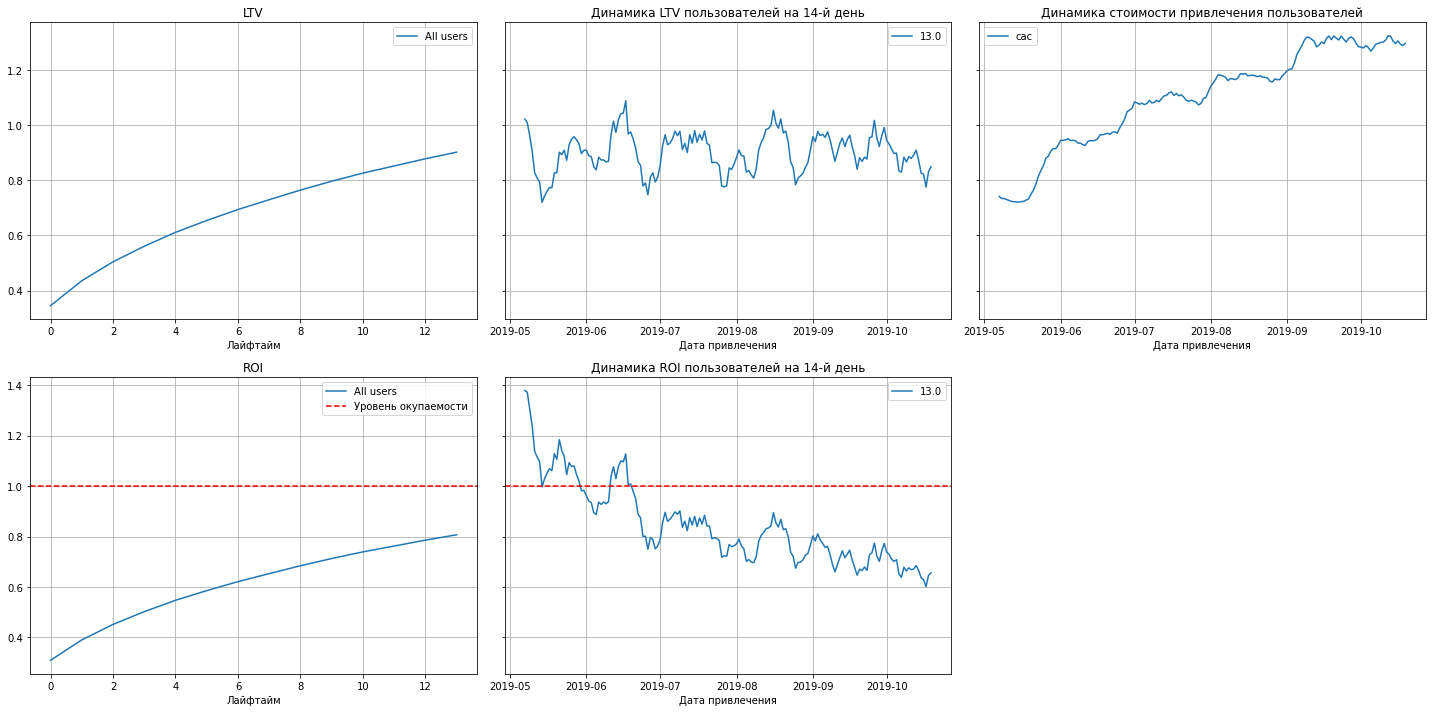

In [174]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

1. Реклама не окупается. ROI в конце второй недели — чуть выше 80%.
2. CAC нестабилен. С большей вероятностью это происходит из-за увеличения рекламного бюджета, которое мы увидели ранее на графиках расходов по каналам привлечения.
3. На LTV не влияет сезонный фактор, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
4. Стабильно окупались лишь те пользователи, которые были привлечены до июня 2019 года. Были моменты окупаемости в июне, но потом произошло окончательное падение в неокупаемость.

#### Проверим конверсию пользователей и динамику её изменения. Построим и изучим графики конверсии и удержания.

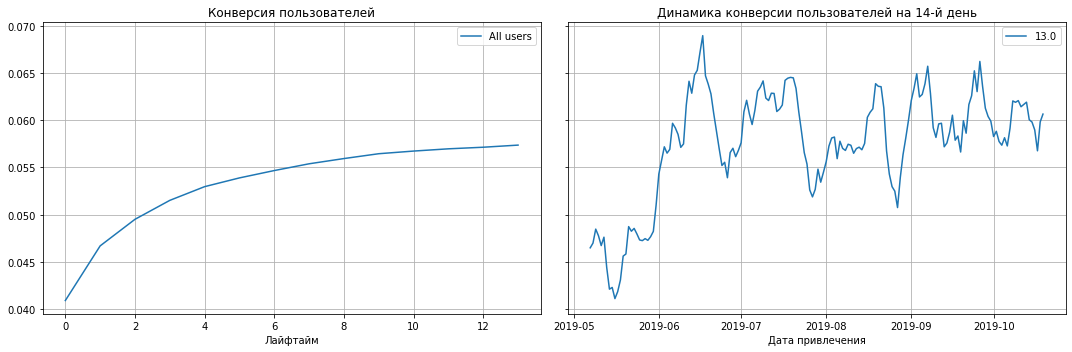

In [175]:
# смотрим общую конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Общая конверсия пользователей растёт: от 4% в первый день «жизни» пользователей до 5,75% на четырнадцатый день.

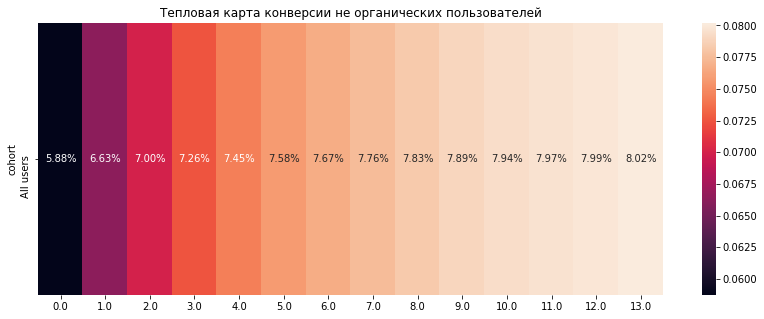

In [176]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_costs, orders, datetime(2019, 11, 1).date(), 14
)

# строим хитмэп по таблице конверсии
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии не органических пользователей')
plt.show() 

Конверсия пользователей с не органических каналов заметно выше и растёт в динамике: от 5,88% в первый день «жизни» пользователей до 8,02% на четырнадцатый день.

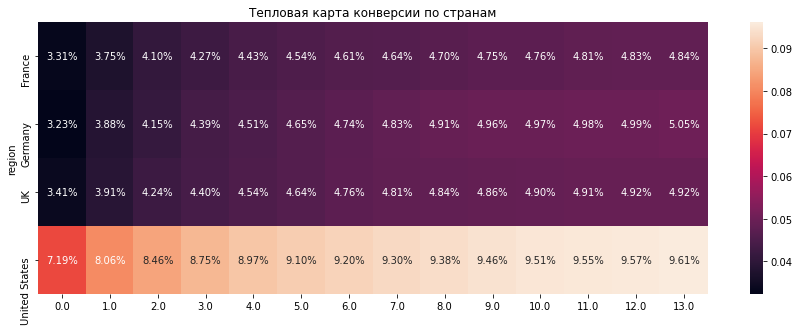

In [177]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_costs, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
plt.show() 

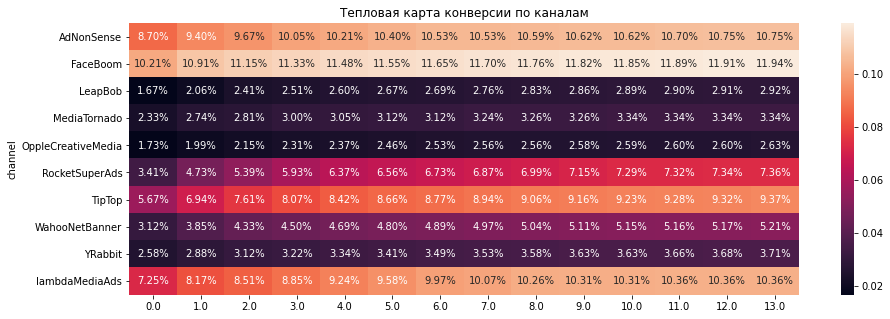

In [178]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_costs, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по каналам')
plt.show() 

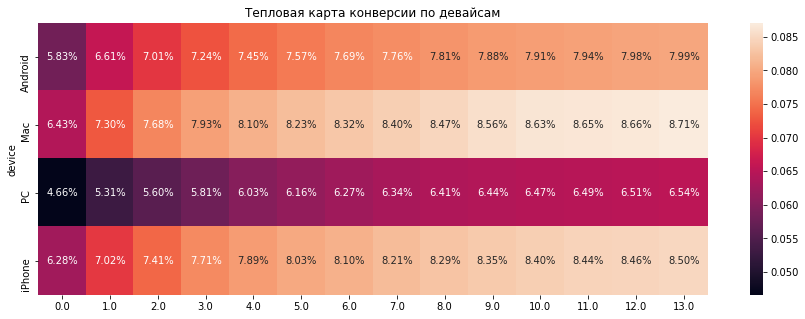

In [179]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles_costs, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по девайсам')
plt.show() 

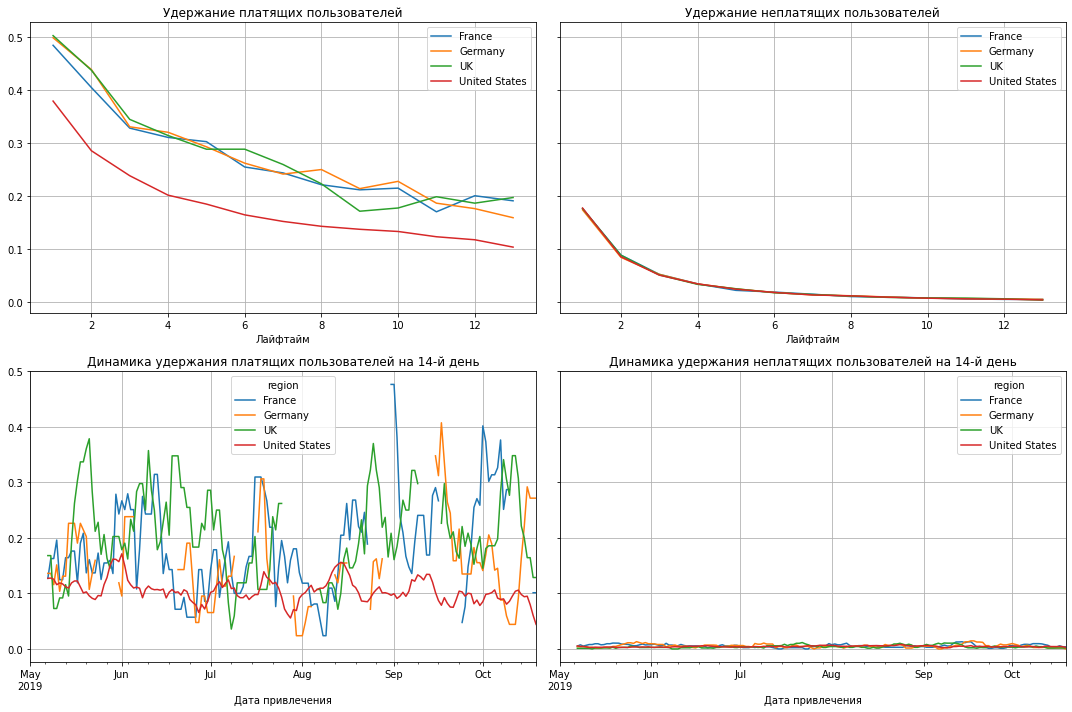

In [180]:
# смотрим удержание
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи из United States стабильно плохо удерживаются. Для платящих пользователей United States удержание 14-го дня ниже, чем в остальных странах.
Очевидно существует проблема в подходе медиапланирования для этого региона, разберемся детальнее при подсчете метрик по кагортным разбивкам.

Посомтрим удержание по каналам.

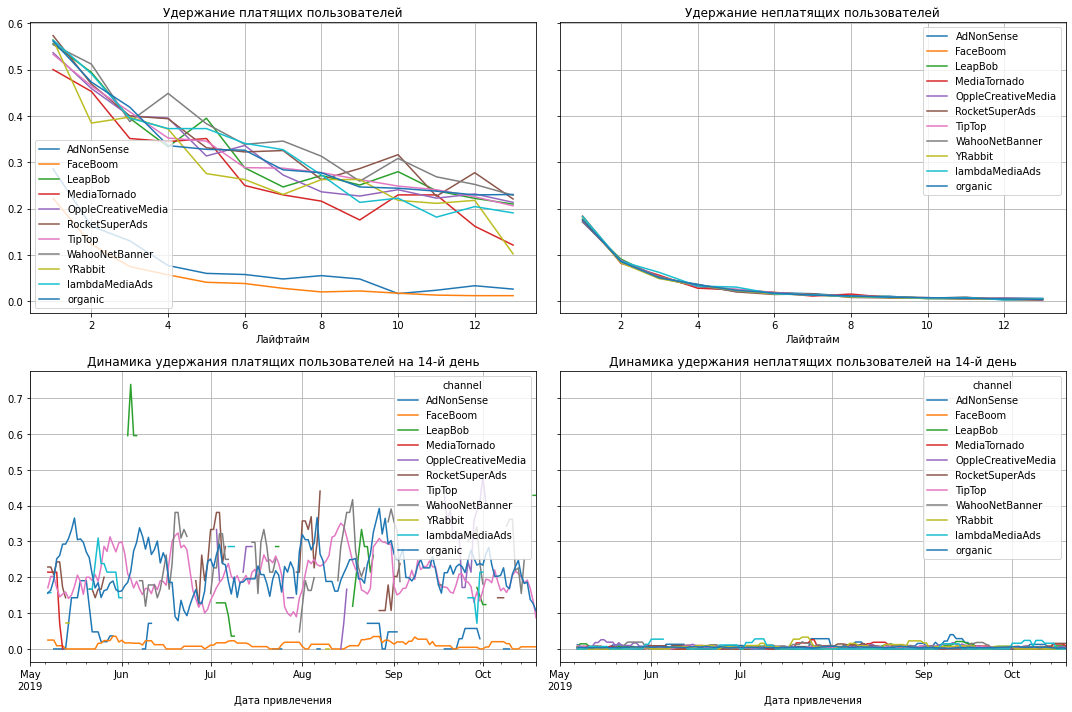

In [181]:
# смотрим удержание
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

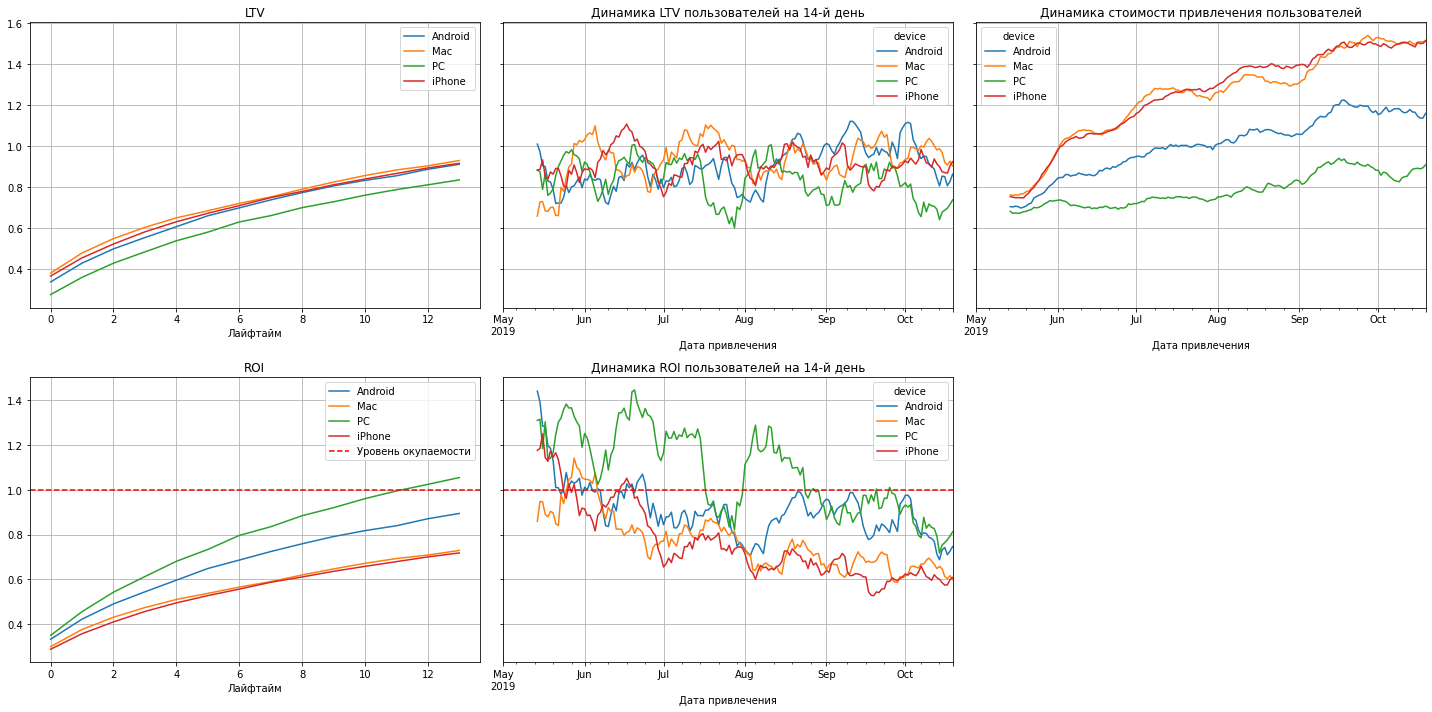

In [182]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

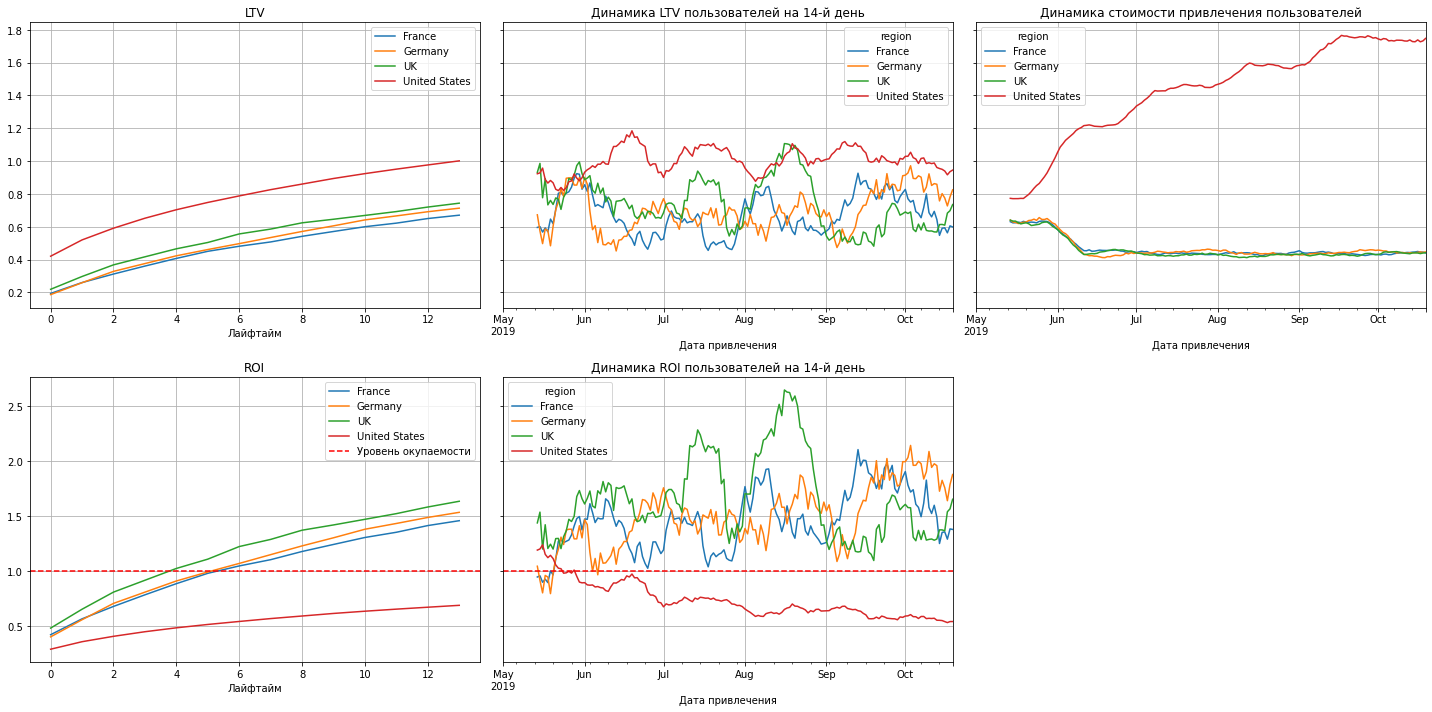

In [183]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

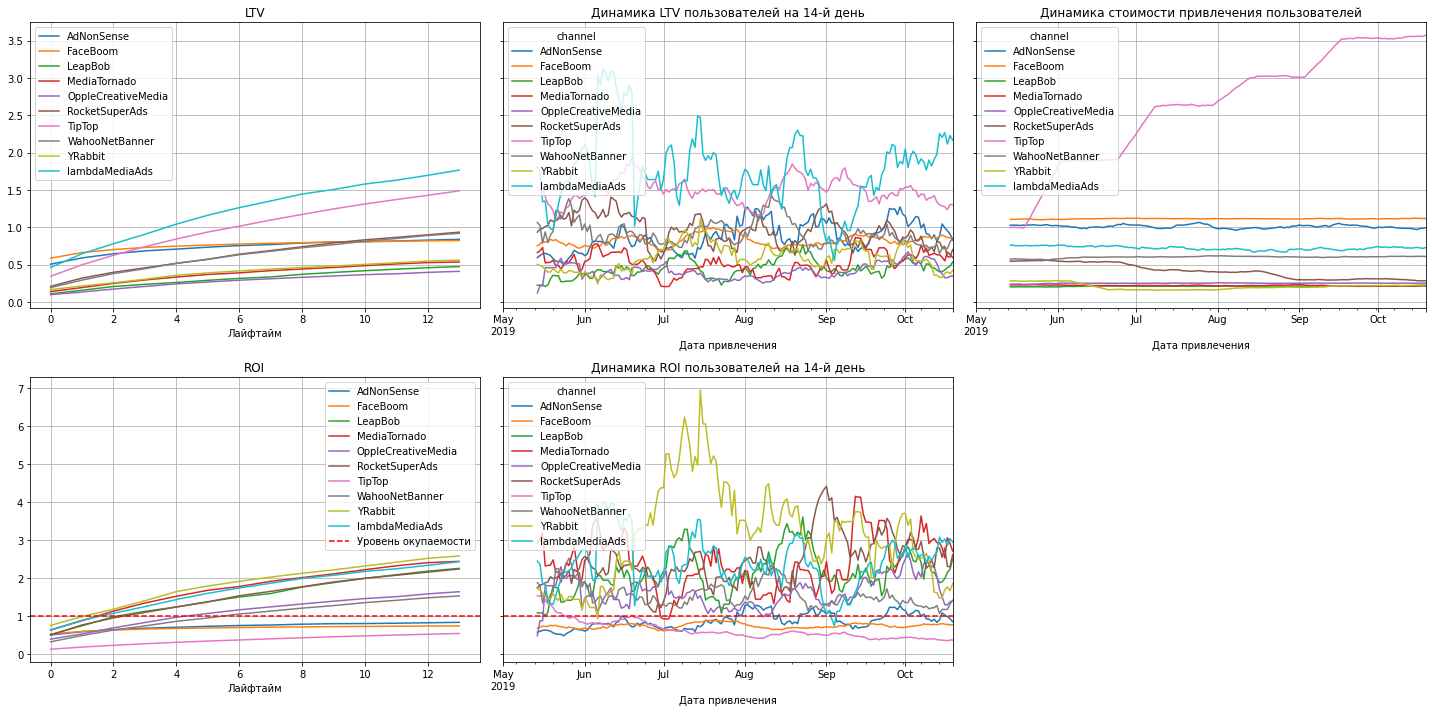

In [184]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Проверим регион каналов-оутсайдеров ["TipTop", "FaceBoom", "AdNonSence"], чтобы исключить плохие рузультаты маркетинга из-за страны или платформы.

In [185]:
profiles_costs_bad = profiles_costs.query(
    'channel == ["TipTop", "FaceBoom", "AdNonSense"]')

print(profiles_costs_bad['region'].value_counts())
print(profiles_costs_bad['device'].value_counts())

United States    48705
France            1366
UK                1295
Germany           1219
Name: region, dtype: int64
iPhone     22634
Mac        12495
Android    10873
PC          6583
Name: device, dtype: int64


Как и ожидалось, эта "большая тройка" актуальна в основном в United States и тянет за собой показатели окупаемости в разбивке по девайсам и регионам.

#### Дополнительное исследование 

Исключим каналы "TipTop", "FaceBoom", "AdNonSence" из датафрейма, чтобы оценить метрики.

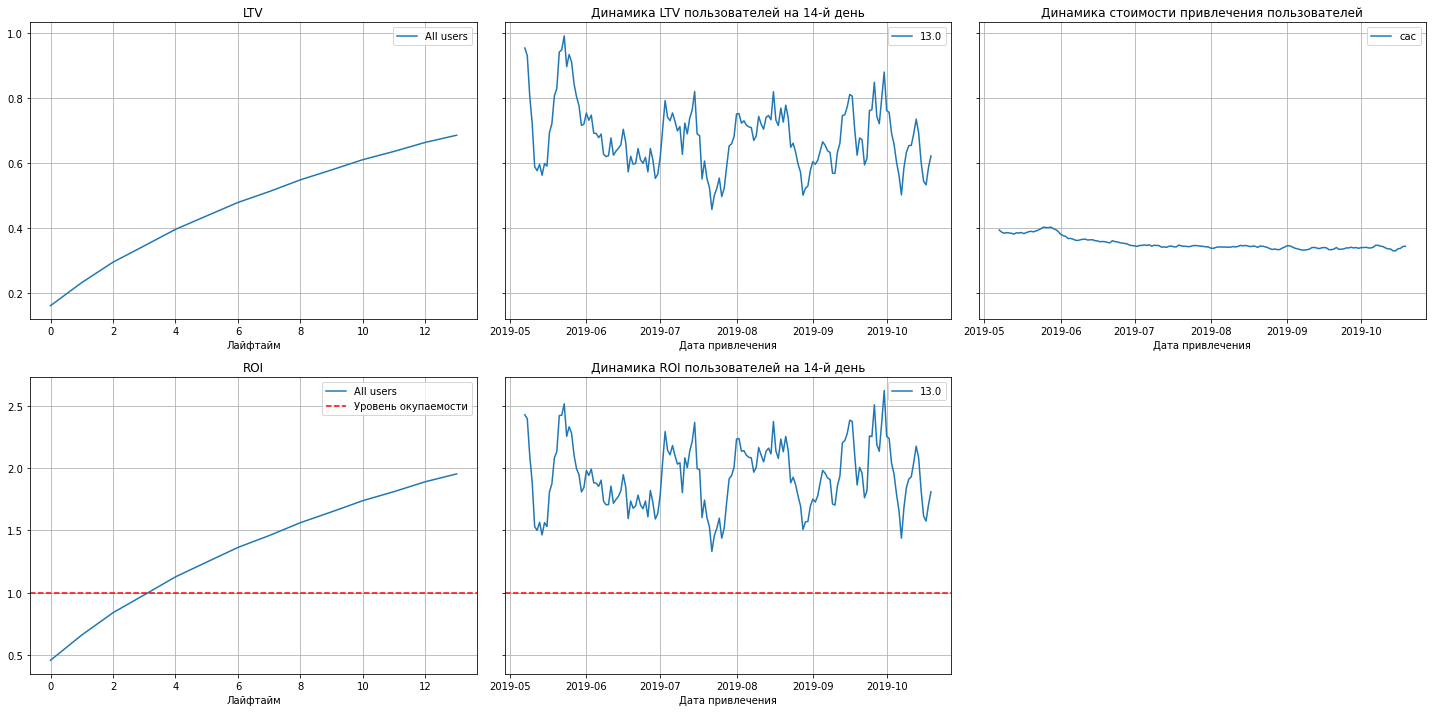

In [186]:
profiles_costs_nott = profiles_costs.query(
    'channel != ["TipTop", "FaceBoom", "AdNonSense"]') # выгрузим данные без каналов TipTop, FaceBoom, AdNonSence

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs_nott, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

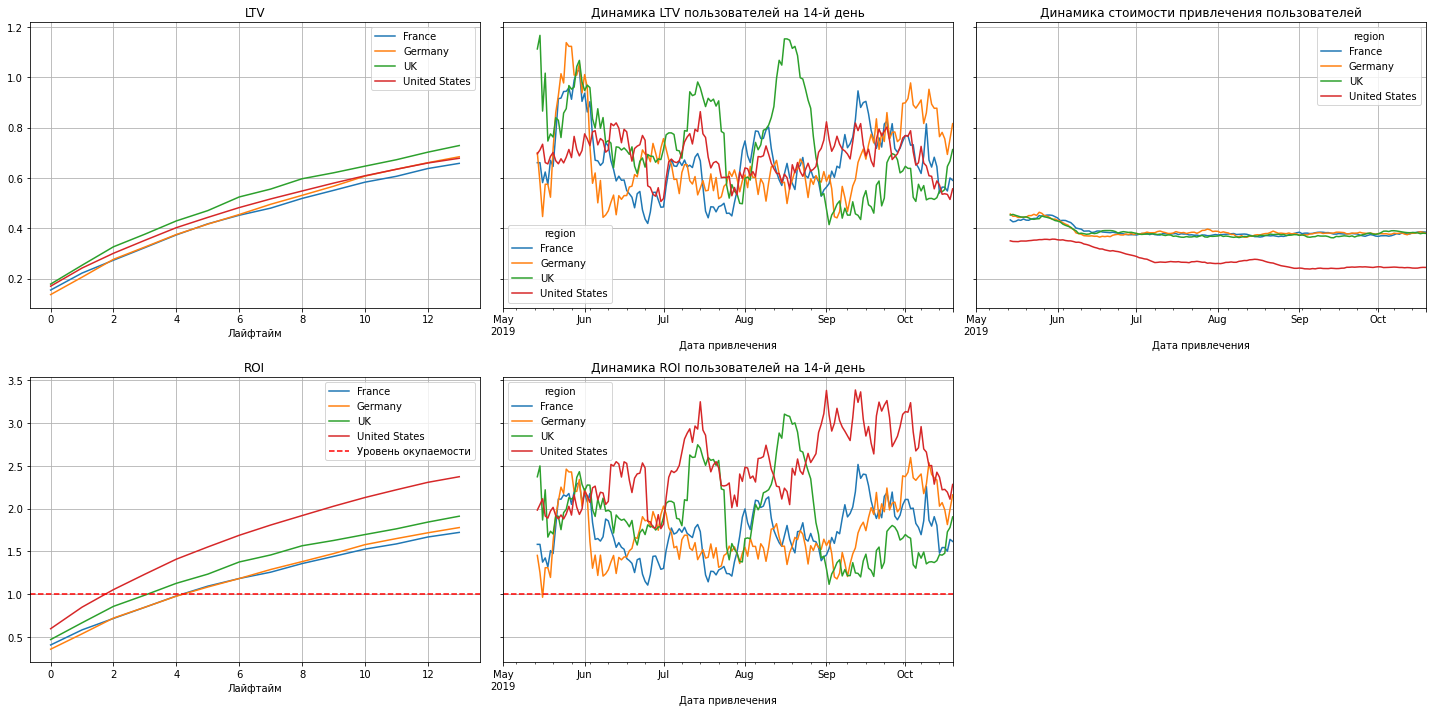

In [187]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs_nott, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

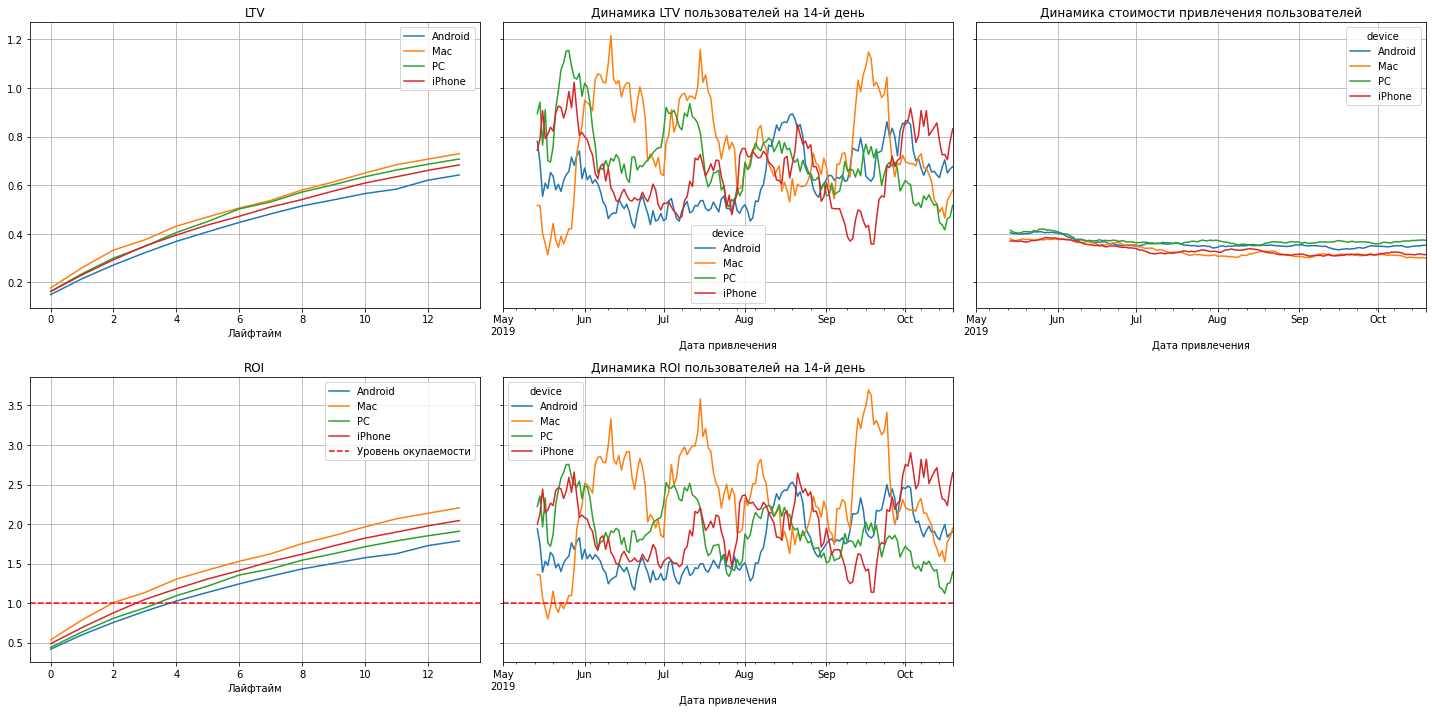

In [188]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs_nott, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

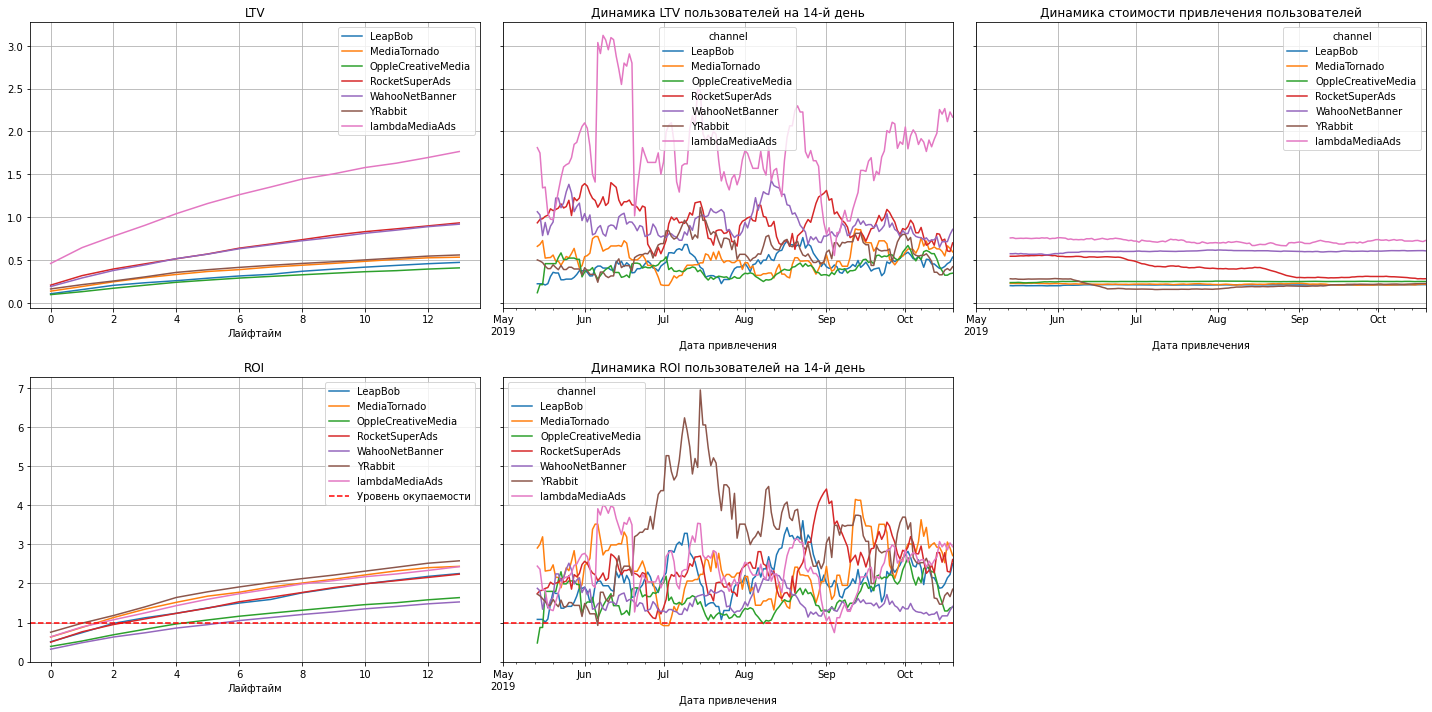

In [189]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_costs_nott, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Мы видим, что без этих трех каналов затраты на рекламу начинают окупаться уже на пятый день, стоимость клиента стабилизируется, а United States выходит в лидеры по окупаемости.

<div class="alert alert-block alert-info">
    
Данные по США  
</div>

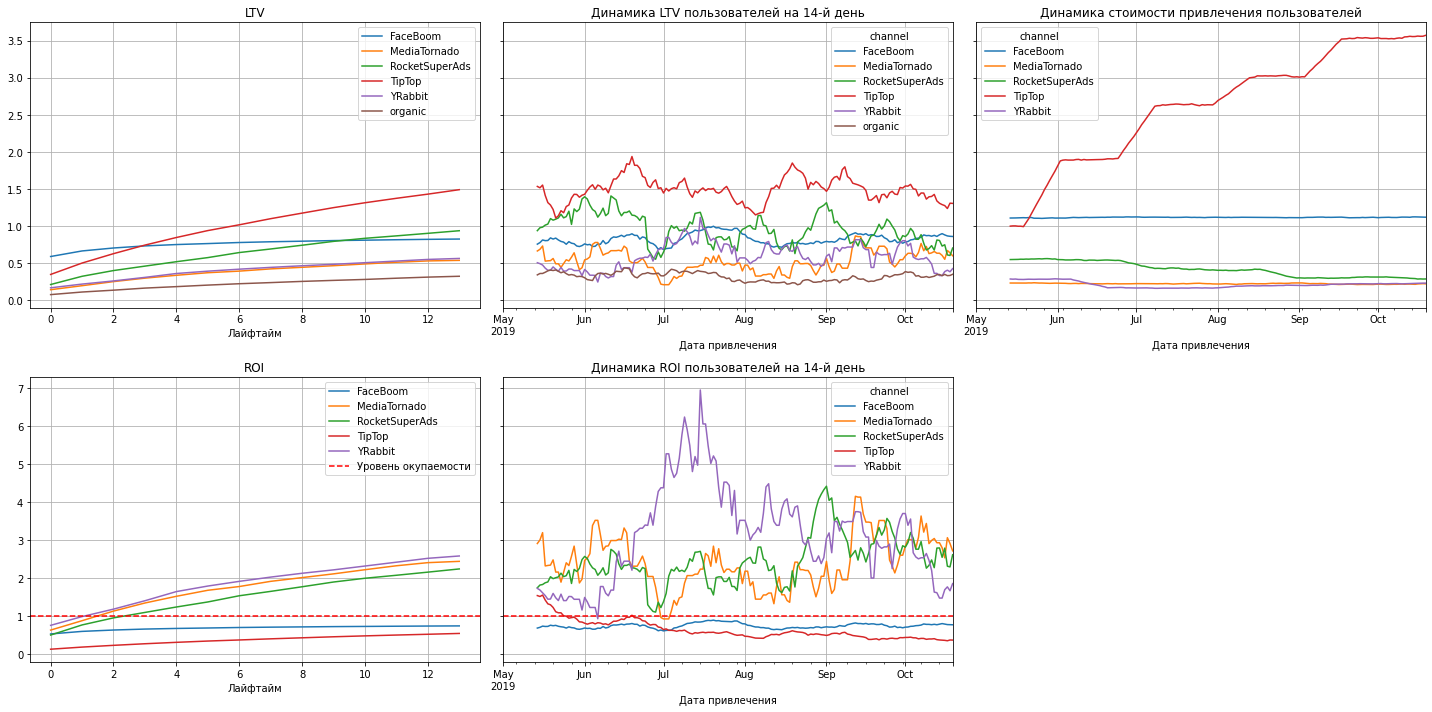

In [190]:
profiles_usa = profiles.query('region == "United States"')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

<div class="alert alert-block alert-info">
    
Так как основные пробоемы окупаемости мы обнаружиди в регионе США, сформируем список рекомендаций отдельно для него:
    
    - исключить канал TipTop из медиапланирования до проведения AB теста, успешность которого будет определяться показателями ROI
    
    - увеличить финансирование для каналов YRabbit, MediaTornado, RocketSuperAds, тк они имеют положительную динамику окупаемости и низкую стоимость привлечения клиента.
    
    - поработать над увеличением показателя удержания пользователей из канала FaceBoom. Возможно, маркетинг отделу стоит обратить внимание на дополнительные активности, чтобы задержать клиента. Например, рассылка промокодов на седьмой день жизни клиента.
</div>

#### Вывод

- Окупается ли реклама, направленная на привлечение пользователей в целом?

Реклама не окупается. ROI в конце второй недели — чуть выше 80%. CAC нестабилен. 
Это происходит из-за увеличения рекламного бюджета для канала TipTop, которое мы увидели ранее на графиках расходов по каналам привлечения и подтвердили графиками окупаемости рекламы с разбивкой по рекламным каналам и Дополнительным исследованием. Каналы FaceBoom, AdNonSence показывают стабильные метрики CAC и отличную конверсию, но пользователи из этих каналов не удерживаются, что негативно влияет на показатели рекламных кампаний.


- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Страны и устройства не являются источником плохих результатов маркетинга. Истиная причина - увеличение рекламного бюджета для каналов TipTop, FaceBoom, AdNonSence, которые не окупаются.

- Чем могут быть вызваны проблемы окупаемости?

TipTop - очень дорогой канал, тянущий деньги. FaceBoom приводит платящих пользователей с низким качеством, они быстро уходят. В среднем пользователь из источника TipTop стоил 2.799003 условных денег. На втором месте по стоимости CAC канал FaceBoom, который почти в три раза дешевле лидируещго и составляет 1.113286 условных денег.

Проблемы окупаемости связаны с некорректным медипланированием. Судя по показателям выдающейся конверсии с разбивкой по странам для United States, которая более чем в два раза выше по сравнению со странами-конкурентками (7,19% против ~3,3) и высокому LTV у TipTop, FaceBoom, AdNonSence с разбивкой по каналам, маркетологи использовали только эти метрики для планирования бюджета, не уделяя внимание окупаемости рекламы по источникам привлечения. 

Технически проблемы могут быть связаны с некорректной настройкой рекламного кабинета для данных каналов, неправильная установка моделей оплаты трафика cpc / cpm.

### Вывод

Мы провели маркетинговый анализ развлекательного приложения Procrastinate Pro+ и выяснили, почему несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

В процеесе изучения данных, было выявлено, что пользователи приходят в приложение из следующих стран: United States, Germany, UK, France. На United States приходится больше всего платящих пользователей, у пользователей из France доля платящих ниже всех. Клиенты используют следующие устройства: Mac, iPhone, Android, PC. На MAC приходится больше всего платящих пользователей, на устройства PC - меньше всего платящих пользователей.

Всего продукт использует 11 источников привлечения трафика. Доля платящих самая высокая у канала FaceBoom, а самая низкая у organic. Но organic привлекает клиентов больше остальных каналов и он условно бесплатный. 

Больше всего денег на маркетинг ушло в канал TipTop - более половины от всего рекламного бюджета. На втором месте источник FaceBoom. Наименьшие затраты у каналов YRabbit и MediaTornado.

Расходы во времени (по неделям и месяцам) на маркетинг распределены равномерно по каждому источнику, за исключением расходов на TipTop. После 20-ой недели началось систематическое вливание денежных средств в канал, сумма расходов на который уже в начале рассмариваего периода почти в два раза обгоняла сумму расходов второго лидера - FaceBoom.

Неэффективность привлечения пользователей обоснована низким ROI (в конце второй недели — чуть выше 80%), при том что бизнесу для выхода в окупаемость требуется ROI 100% уже к концу второй недели. 

CAC нестабилен. Это происходит из-за увеличения рекламного бюджета для каналов TipTop, FaceBoom, AdNonSence, которое мы увидели ранее на графиках расходов по каналам привлечения и подтвердили графиками окупаемости рекламы с разбивкой по рекламным каналам и Дополнительным исследованием, исключив каналы из выборки.

Проблемы окупаемости связаны с некорректным медипланированием. Судя по показателям выдающейся конверсии с разбивкой по странам для United States, которая более чем в два раза выше по сравнению со странами-конкурентками (7,19% против ~3,3) и высокому LTV у TipTop, FaceBoom, AdNonSence с разбивкой по каналам, маркетологи использовали только эти метрики для планирования бюджета, не уделяя внимание окупаемости рекламы по источникам привлечения.

Кроме того, технически проблемы могут быть связаны с некорректной настройкой рекламного кабинета для данных каналов, неправильная установка моделей оплаты трафика cpc / cpm.

Рекомендации отделу маркетинга:

Каналы LambdaMediaAds, YRabbit, LeapBob, RocketSuperAds показывают отличную окупаемость в рамках всего периода и выходят в положительный ROI уже на третий день. Бюджет для этих каналов можно увеличивать.

Рекомендую отделу маркетинга исключить канал TipTop, из медиапланирвоания и выходить в него только после проведения AB тестирования, результаты которого будет основаны на показателях ROI. 

Так как основные пробоемы окупаемости мы обнаружиди в регионе США, сформируем список рекомендаций отдельно для него:

    * исключить канал TipTop из медиапланирования до проведения AB теста, успешность которого будет определяться показателями ROI
    
    * увеличить финансирование для каналов YRabbit, MediaTornado, RocketSuperAds, тк они имеют положительную динамику окупаемости и низкую стоимость привлечения клиента.
    
    * поработать над увеличением показателя удержания пользователей из канала FaceBoom. Возможно, маркетинг отделу стоит обратить внимание на дополнительные активности, чтобы задержать клиента. Например, рассылка промокодов на седьмой день жизни клиента.
